# (05) Sim -- behavior of ```filter()``` when ```dim=33```

**Motivation**: Study its behavior, choose appropriate ```accept_n```, ```min_obj_size```, etc. Finally, generate and save. 

***Note***: The following are changed from previous iteration:
- Changed ```obj_r``` from $0.25 \rightarrow 0.3$ so the objects are a bit bigger.
- Changed ```obj_bound``` from $0.97 \rightarrow 1.0$ so now all alphas are accepted when sampling obj pos.
<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()

def _sizes_hist(of, obj_i: int = 0):
    fig, axes = create_figure(2, 1, (10, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 400, 401) - 0.5, stat='percent', ax=axes[0])
    sns.histplot(size_pix, bins=np.linspace(0, 400, 401) - 0.5, stat='percent', ax=axes[1])
    axes[1].set_xlim((-1, 81))
    
    for color, thres in zip(['magenta', 'k', 'g', 'r', 'k'], [2, 4, 6, 8, 10]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        for ax in axes.flat:
            ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    axes[0].legend(fontsize=12)
    
    plt.show()

## Accept explore

In [3]:
from skimage.transform import resize

kws = dict(
    n=int(1e3),
    dim=33,
    fov=45.0,
    obj_r=0.3,
    obj_bound=1.0,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 10.5

{
    'n': 1000,
    'dim': 33,
    'fov': 45.0,
    'obj_r': 0.3,
    'obj_bound': 1.0,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [4]:
from base.dataset import simulation_combos
combos = simulation_combos()
print(combos)

[('fixate', 0), ('fixate', 1), ('transl', 0), ('transl', 1), ('obj', 1)]

In [5]:
for category, n_obj in combos:
    kws['category'] = category
    kws['n_obj'] = n_obj
    of = ROFL(**kws).compute_coords()
    _ = of.compute_flow()
    accept = of.filter(min_obj_size)
    
    msg = f"category: {category}, # objects = {n_obj}    ||    "
    msg += f"accepted: {100 * accept.sum() / len(accept):0.1f}"
    msg += f" %,  (min obj size = {min_obj_size})"
    print(msg)

category: fixate, # objects = 0    ||    accepted: 100.0 %,  (min obj size = 10.5)

category: fixate, # objects = 1    ||    accepted: 93.7 %,  (min obj size = 10.5)

category: transl, # objects = 0    ||    accepted: 100.0 %,  (min obj size = 10.5)

category: transl, # objects = 1    ||    accepted: 93.7 %,  (min obj size = 10.5)

category: obj, # objects = 1    ||    accepted: 93.7 %,  (min obj size = 10.5)

## Plot dists ```fixate-1```

In [6]:
kws['n_obj'] = 1
kws['n'] = int(3e5)
kws['category'] = 'fixate'
min_obj_size = 10.5

In [7]:
%%time

of = ROFL(**kws).compute_coords()
_ = of.compute_flow()
accept = of.filter(min_obj_size)
of.gamma = None

s, pcs, titles = _do_pca(of.alpha_dot[accept])

CPU times: user 19min 50s, sys: 5min 7s, total: 24min 58s
Wall time: 14min 5s


In [8]:
accept.sum()

281020

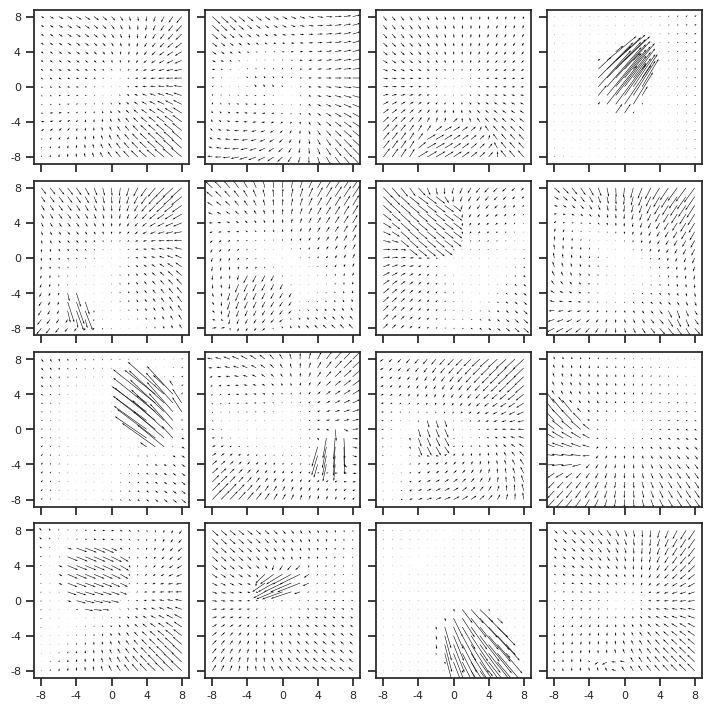

In [9]:
_ = show_opticflow(resize(of.alpha_dot[accept][:16], (16, 17, 17, 2)))

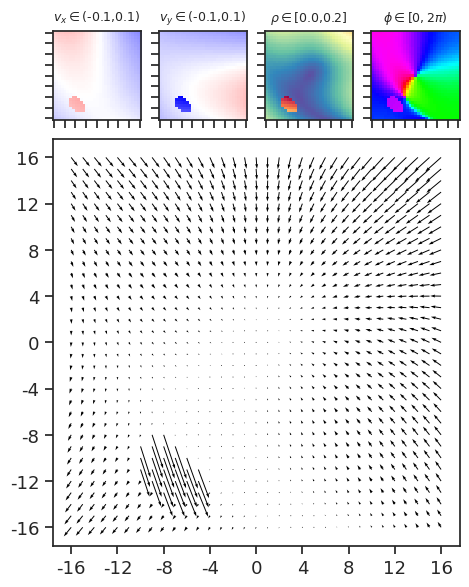

In [10]:
_ = show_opticflow_full(of.alpha_dot[accept][4])

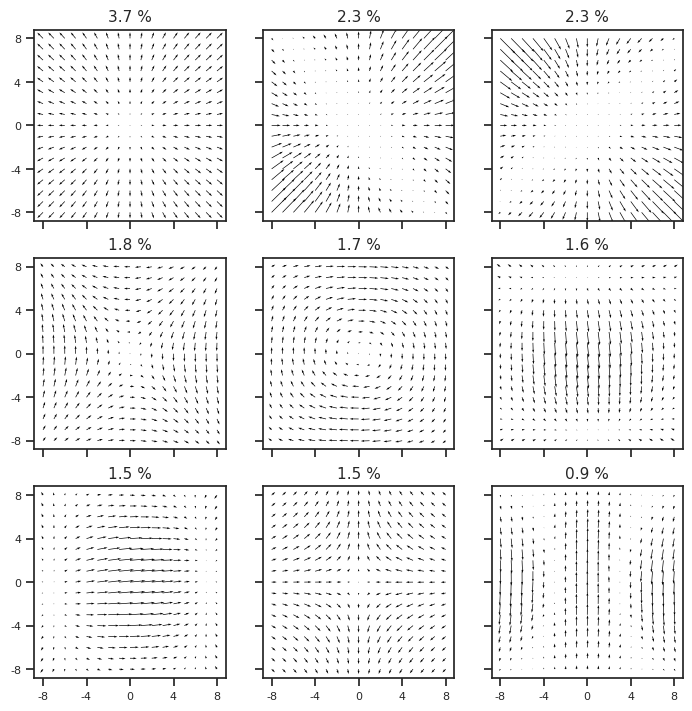

In [11]:
show_opticflow(resize(pcs[:9], (9, 17, 17, 2)), num=3, titles=titles, scale=None);

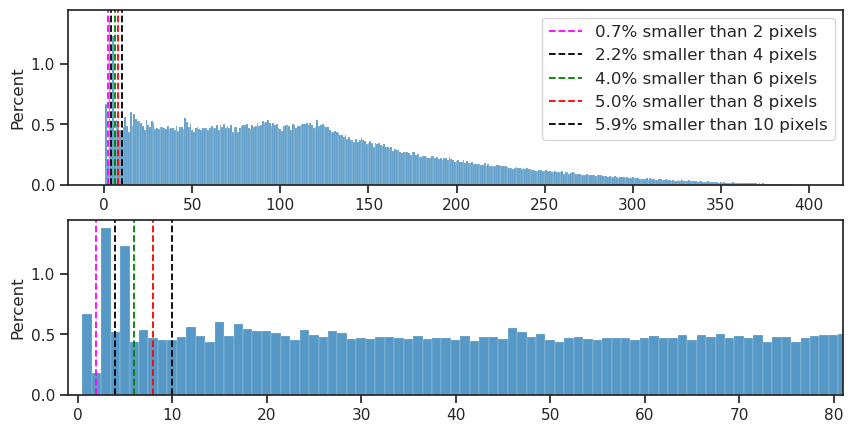

In [12]:
_sizes_hist(of)

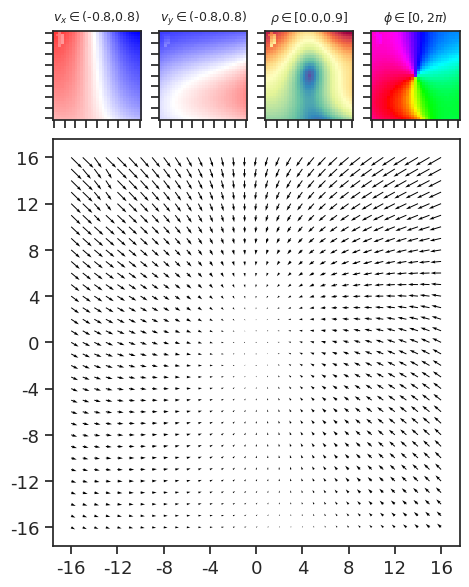

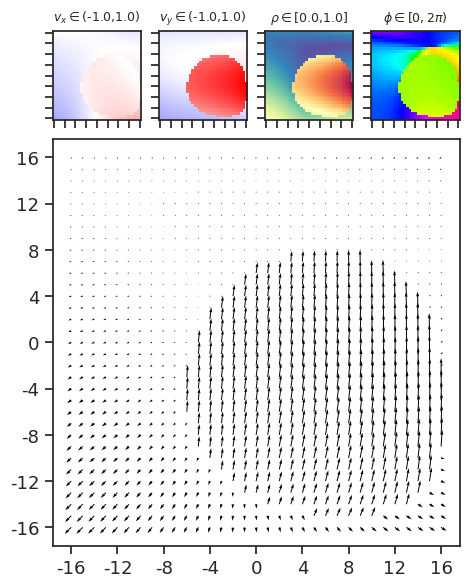

In [13]:
size_pix = of.objects[0].size * of.dim ** 2
i = np.argmin(size_pix[accept])
_ = show_opticflow_full(of.alpha_dot[accept][i])

i = np.argsort(size_pix[accept])[-1]
_ = show_opticflow_full(of.alpha_dot[accept][i])

In [14]:
np.min(size_pix[accept]), np.max(size_pix[accept])

(10.999999999999996, 419.0)

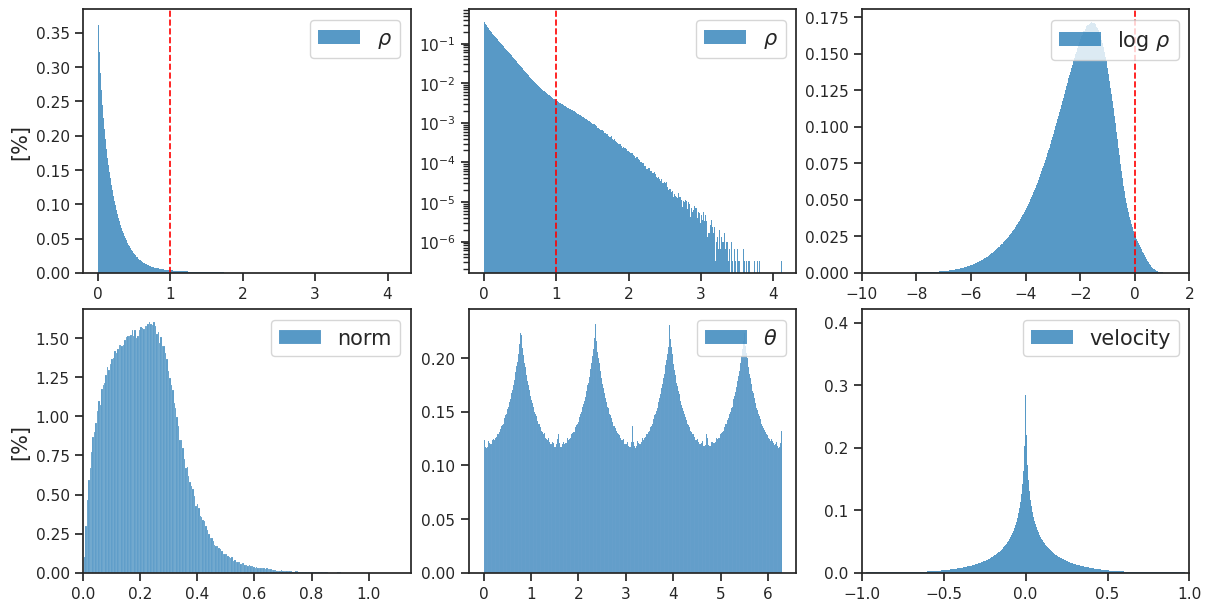

CPU times: user 16min 41s, sys: 6min 17s, total: 22min 59s
Wall time: 22min 59s


In [15]:
%%time

_ = plot_opticflow_hist(of.alpha_dot[accept])

## Print generative factors

- After fixing the bug in terrain

In [16]:
kws['n'] = 1000
for category, n_obj in combos:
    kws['category'] = category
    kws['n_obj'] = n_obj
    of = ROFL(**kws).compute_coords()
    _ = of.compute_flow()
    f, g, f_aux, g_aux = of.groundtruth_factors()
    f_with_mu_sig = {}
    for k, v in zip(f, g.T):
        mu, sd = np.mean(v), np.std(v)
        if sd < 1e-3:
            raise RuntimeError
        f_with_mu_sig[k] = (np.round(mu, 3), np.round(sd, 3))
    f_aux_with_mu_sig = {}
    for k, v in zip(f_aux, g_aux.T):
        mu, sd = np.mean(v), np.std(v)
        if sd < 1e-3:
            raise RuntimeError
        f_aux_with_mu_sig[k] = (np.round(mu, 3), np.round(sd, 3))
    print('-' * 80, f"\ncategory: {category}, n_obj = {n_obj}")
    print(f"factors:\n{f_with_mu_sig}")
    print(f"factors_aux:\n{f_aux_with_mu_sig}\n", '~' * 80)
    print('\n\n')

-------------------------------------------------------------------------------- 
category: fixate, n_obj = 0

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (0.51, 0.294), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825)}

factors_aux:
{'slf_v_x': (0.002, 0.349), 'slf_v_y': (-0.001, 0.336), 'slf_v_z': (-0.005, 0.334)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: fixate, n_obj = 1

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (0.51, 0.294), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825), 'obj0_alpha_x': (-0.004, 0.441), 
'obj0_alpha_y': (0.006, 0.439), 'obj0_z': (0.753, 0.143), 'obj0_v_norm': (0.5, 0.281), 
'obj0_v_theta': (1.616, 0.694), 'obj0_v_phi': (3.116, 1.816)}

factors_aux:
{'slf_v_x': (0.002, 0.349), 'slf_v_y': (-0.001, 0.336), 'slf_v_z': (-0.005, 0.334), 
'obj0_size_eff': (0.102, 0.072), 'obj0_size': (0.102, 0.072), 'obj0_theta': (0.559, 0.196), 
'obj0_phi': (3.114, 1.798), 'obj0_x': (0.027, 0.761), 'obj0_y': (0.017, 0.791), 
'obj0_distance': (1.178, 0.638), 'obj0_dx': (0.004, 0.634), 'obj0_dy': (0.027, 0.64), 
'obj0_dz': (-0.247, 0.143), 'obj0_v_x': (0.01, 0.328), 'obj0_v_y': (0.013, 0.331), 
'obj0_v_z': (-0.016, 0.334), 'obj0_dv_x': (0.007, 0.481), 'obj0_dv_y': (0.014, 0.476), 
'obj0_dv_z': (-0.01, 0.469), 'obj0_dv_norm': (0.749, 0.343), 'obj0_dv_theta': (1.596, 0.686),
'obj0_dv_phi': (3.078, 1.84)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: transl, n_obj = 0

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (0.51, 0.294), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825)}

factors_aux:
{'slf_v_x': (0.002, 0.349), 'slf_v_y': (-0.001, 0.336), 'slf_v_z': (-0.005, 0.334)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: transl, n_obj = 1

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'slf_v_norm': (0.51, 0.294), 
'slf_v_theta': (1.591, 0.685), 'slf_v_phi': (3.159, 1.825), 'obj0_alpha_x': (-0.004, 0.441), 
'obj0_alpha_y': (0.006, 0.439), 'obj0_z': (0.753, 0.143), 'obj0_v_norm': (0.5, 0.281), 
'obj0_v_theta': (1.616, 0.694), 'obj0_v_phi': (3.116, 1.816)}

factors_aux:
{'slf_v_x': (0.002, 0.349), 'slf_v_y': (-0.001, 0.336), 'slf_v_z': (-0.005, 0.334), 
'obj0_size_eff': (0.102, 0.072), 'obj0_size': (0.102, 0.072), 'obj0_theta': (0.559, 0.196), 
'obj0_phi': (3.114, 1.798), 'obj0_x': (0.027, 0.761), 'obj0_y': (0.017, 0.791), 
'obj0_distance': (1.178, 0.638), 'obj0_dx': (0.004, 0.634), 'obj0_dy': (0.027, 0.64), 
'obj0_dz': (-0.247, 0.143), 'obj0_v_x': (0.01, 0.328), 'obj0_v_y': (0.013, 0.331), 
'obj0_v_z': (-0.016, 0.334), 'obj0_dv_x': (0.007, 0.481), 'obj0_dv_y': (0.014, 0.476), 
'obj0_dv_z': (-0.01, 0.469), 'obj0_dv_norm': (0.749, 0.343), 'obj0_dv_theta': (1.596, 0.686),
'obj0_dv_phi': (3.078, 1.84)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

-------------------------------------------------------------------------------- 
category: obj, n_obj = 1

factors:
{'fix_x': (0.023, 0.402), 'fix_y': (-0.01, 0.411), 'obj0_alpha_x': (-0.004, 0.441), 
'obj0_alpha_y': (0.006, 0.439), 'obj0_z': (0.753, 0.143), 'obj0_v_norm': (0.5, 0.281), 
'obj0_v_theta': (1.616, 0.694), 'obj0_v_phi': (3.116, 1.816)}

factors_aux:
{'obj0_size_eff': (0.102, 0.072), 'obj0_size': (0.102, 0.072), 'obj0_theta': (0.559, 0.196), 
'obj0_phi': (3.114, 1.798), 'obj0_x': (0.027, 0.761), 'obj0_y': (0.017, 0.791), 
'obj0_distance': (1.178, 0.638), 'obj0_dx': (0.004, 0.634), 'obj0_dy': (0.027, 0.64), 
'obj0_dz': (-0.247, 0.143), 'obj0_v_x': (0.01, 0.328), 'obj0_v_y': (0.013, 0.331), 
'obj0_v_z': (-0.016, 0.334)}
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~